# IFT6135-A2022
# Assignment 3: VAE Practical

You must fill in your answers to various questions in this notebook, following which you must export this notebook to a Python file named `vae.py` and submit it on Gradescope.

Only edit the functions specified in the PDF (and wherever marked – `# WRITE CODE HERE`). Do not change definitions or edit the rest of the template, else the autograder will not work.

**Make sure you request a GPU runtime!**

## VAE Basics

Variational Autoencoders are generative latent-variable models that are popularly used for unsupervised learning and are aimed at maximizing the log-likelihood of the data, that is, maximizing $\sum\limits_{i=1}^N \log p(x_i; \theta)$ where $N$ is the number of data samples available. The generative story is as follows

\begin{align*}
  z &\sim \mathcal{N}(0, I) \\
  x | z &\sim \mathcal{N}(\mu_\theta(z), \Sigma_\theta(z))
\end{align*}

Given $\mu_\theta(\cdot)$ and $\Sigma_\theta(\cdot)$ are parameterized as arbitrary Neural Networks, one cannot obtain the log-likelihood $\log \mathbb{E}_{z}[p(x | z, \theta)]$ in closed form and hence has to rely on variational assumptions for optimization.

One way of optimizing for log-likelihood is to use the variational distribution $q_\phi(z | x)$, which with a little bit of algebra leads to the ELBO, which is

\begin{align*}
  ELBO = \sum_{i=1}^N \left( \mathbb{E}_{z\sim q_\phi(z|x_i)} [\log p_\theta(x_i | z)] + \mathbb{KL}[q_\phi(z|x_i) || \mathcal{N}(0, I)] \right)
\end{align*}

This is the objective that we use for optimizing VAEs, where different flavours of VAE can be obtained by changing either the approximate posterior $q_\phi$, the conditional likelihood distribution $p_\theta$ or even the standard normal prior.

The aim of this assignment would be to code a simple version of a VAE, where $q_\phi(z|x)$ will be parameterized as $\mathcal{N}(\mu_\phi(x), \Sigma_\phi(x))$ where $\mu(x)$ is a mean vector and $\Sigma(x)$ will be a **diagonal covariance matrix**, that is, it will only have non-zero entries on the diagonal.

The likelihood $p_\theta(x|z)$ will also be modeled as a Gaussian Distribution $\mathcal{N}(\mu_\theta(z), I)$ where we parameterize the mean with another neural network but for simplicity, consider the identity covariance matrix.

For details about VAEs, please refer to [Kingma's Paper](https://arxiv.org/abs/1312.6114) and the [Rezende's Paper](https://arxiv.org/abs/1401.4082)

In [ ]:
#!pip install -q -U datasets matplotlib==3.1.1 tqdm

import random
import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms

from pathlib import Path
from torch.utils.data import DataLoader

def fix_experiment_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_experiment_seed()

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
device = "cuda" if torch.cuda.is_available() else "cpu"

     |████████████████████████████████| 451 kB 34.9 MB/s 
     |████████████████████████████████| 13.1 MB 4.6 MB/s 
     |████████████████████████████████| 182 kB 56.3 MB/s 
     |████████████████████████████████| 115 kB 55.2 MB/s 
     |████████████████████████████████| 212 kB 60.3 MB/s 
     |████████████████████████████████| 127 kB 63.4 MB/s 


## Set up the hyperparameters
- Batch Size
- Latent Dimensionality
- Learning Rate

In [ ]:
# Training Hyperparameters
batch_size = 64   # Batch Size
z_dim = 32        # Latent Dimensionality
lr = 1e-4         # Learning Rate

In [ ]:
# Define Dataset Statistics
image_size = 32
input_channels = 3

# Resize and Normalize the Data
transform = Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# Helper Functions
def show_image(image, nrow=8):
  # Input: image
  # Displays the image using matplotlib
  grid_img = make_grid(image.detach().cpu(), nrow=nrow, padding=0)
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off')

def transforms_examples(examples):
  # Helper function to perform transformations on the input images
  if "image" in examples:
     examples["pixel_values"] = [transform(image) for image in examples["image"]]
     del examples["image"]
  else:
     examples["pixel_values"] = [transform(image) for image in examples["img"]]
     del examples["img"]

  return examples

In [ ]:
# Load dataset from the hub, normalize it and create the dataloader
def get_dataloaders():
  dataset = load_dataset("svhn", 'cropped_digits', cache_dir='./data')
  transformed_dataset = dataset.with_transform(transforms_examples)
  train_dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True, drop_last=True)
  test_dataloader = DataLoader(transformed_dataset["test"], batch_size=batch_size, shuffle=False, drop_last=False)

  return train_dataloader, test_dataloader

## Visualize the Data

Lets visualize what our data actually looks like! We are using the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/) which comprises of images of house numbers seen from the streets.

Generating train split:   0%|          | 0/73257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26032 [00:00<?, ? examples/s]

Generating extra split:   0%|          | 0/531131 [00:00<?, ? examples/s]

Dataset svhn downloaded and prepared to /content/./data/svhn/cropped_digits/1.0.0/8e83fcbe6f6078438cd826c7acd29e3de8ee7db44657b535f6d3453235529a31. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([64, 3, 32, 32])


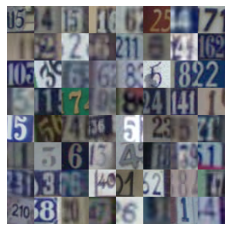

In [ ]:
# Visualize the Dataset
def visualize():
  train_dataloader, _ = get_dataloaders()
  batch = next(iter(train_dataloader))
  print(batch['pixel_values'].shape)

  save_image((batch['pixel_values'] + 1.) * 0.5, './results/orig.png')
  show_image((batch['pixel_values'] + 1.) * 0.5)

if __name__ == '__main__':
  visualize()

## Define the Model Architectures

For our VAE models, we use an encoder network and a decoder network, both of which have been pre-defined for ease of use in this assignment.

Encoder: It is a model that maps input images to the latent space, and in particular, to the parameters of the distribution in the latent space.

Decoder: It is a model that maps a sample in the latent space to a distribution in the observed space.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, nc, nef, nz, isize, device):
    super(Encoder, self).__init__()

    # Device
    self.device = device

    # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
    self.encoder = nn.Sequential(
        nn.Conv2d(nc, nef, 4, 2, padding=1),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(nef),

        nn.Conv2d(nef, nef * 2, 4, 2, padding=1),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(nef * 2),

        nn.Conv2d(nef * 2, nef * 4, 4, 2, padding=1),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(nef * 4),

        nn.Conv2d(nef * 4, nef * 8, 4, 2, padding=1),
        nn.LeakyReLU(0.2, True),
        nn.BatchNorm2d(nef * 8),
    )

  def forward(self, inputs):
    batch_size = inputs.size(0)
    hidden = self.encoder(inputs)
    hidden = hidden.view(batch_size, -1)
    return hidden

class Decoder(nn.Module):
  def __init__(self, nc, ndf, nz, isize):
    super(Decoder, self).__init__()

    # Map the latent vector to the feature map space
    self.ndf = ndf
    self.out_size = isize // 16
    self.decoder_dense = nn.Sequential(
        nn.Linear(nz, ndf * 8 * self.out_size * self.out_size),
        nn.ReLU(True)
    )

    self.decoder_conv = nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ndf * 8, ndf * 4, 3, 1, padding=1),
        nn.LeakyReLU(0.2, True),

        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ndf * 4, ndf * 2, 3, 1, padding=1),
        nn.LeakyReLU(0.2, True),

        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ndf * 2, ndf, 3, 1, padding=1),
        nn.LeakyReLU(0.2, True),

        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(ndf, nc, 3, 1, padding=1)
    )

  def forward(self, input):
    batch_size = input.size(0)
    hidden = self.decoder_dense(input).view(
        batch_size, self.ndf * 8, self.out_size, self.out_size)
    output = self.decoder_conv(hidden)
    return output

# Diagonal Gaussian Distribution

The following class provides a way of setting up the diagonal gaussian distribution, which is parameterized by a mean vector, and a logvar vector of the same shape as the mean vector. The logvar vector denotes the log of the variances on the diagonals of a diagonal covariance matrix.

The task is to implement the following functions:

- Sampling: Provide the methodology of computing a **reparamterized** sample from the given distribution.
- KL Divergence: Compute and return the KL divergence of the distribution with the standard normal, that is, $\mathbb{KL}[\mathcal{N}(\mu, \Sigma) || \mathcal{N}(0, I)]$ where $\Sigma$ is a diagonal covariance matrix.
- Negative Log Likelihood: Given some data $x$, returns the log likelihood under the current gaussian, that is, $\log \mathcal{N}(x | \mu, \Sigma)$
- Mode: Returns the mode of the distribution 

In [ ]:
class DiagonalGaussianDistribution(object):
  # Gaussian Distribution with diagonal covariance matrix
  def __init__(self, mean, logvar=None):
    super(DiagonalGaussianDistribution, self).__init__()
    # Parameters:
    # mean: A tensor representing the mean of the distribution
    # logvar: Optional tensor representing the log of the standard variance
    #         for each of the dimensions of the distribution 

    self.mean = mean
    if logvar is None:
        logvar = torch.zeros_like(self.mean)
    self.logvar = torch.clamp(logvar, -30., 20.)

    self.std = torch.exp(0.5 * self.logvar)
    self.var = torch.exp(self.logvar)

  def sample(self):
    # Provide a reparameterized sample from the distribution
    # Return: Tensor of the same size as the mean
    sample = self.mean + self.std*torch.randn(*self.mean.size())       # WRITE CODE HERE
    return sample

  def kl(self):
    # Compute the KL-Divergence between the distribution with the standard normal N(0, I)
    # Return: Tensor of size (batch size,) containing the KL-Divergence for each element in the batch
    kl_div = -0.5*torch.sum(1+self.logvar-torch.pow(self.mean,2)-torch.exp(self.logvar),dim=1)      # WRITE CODE HERE
    return kl_div

  def nll(self, sample, dims=[1, 2, 3]):
    # Computes the negative log likelihood of the sample under the given distribution
    # Return: Tensor of size (batch size,) containing the log-likelihood for each element in the batch
    negative_ll = 0.5*(np.log(2*np.pi)+self.logvar+(sample-self.mean)**2/self.var)  # WRITE CODE HERE
    negative_ll = torch.sum(negative_ll, dim=dims)
    return negative_ll

  def mode(self):
    # Returns the mode of the distribution
    mode = self.mean      # WRITE CODE HERE
    return mode

# VAE Model

The Variational Autoencoder (VAE) model consists of an encoder network that parameterizes the distribution $q_\phi$ as a Diagonal Gaussian Distribution through the (mean, log variance) parameterization and a decoder network that parameterizes the distribution $p_\theta$ as another Diagonal Gaussian Distribution with an identity covariance matrix.

The task is to implement the following

- Encode: The function that takes as input a batched data sample, and returns the approximate posterior distribution $q_\phi$
- Decode: The function that takes as input a batched sample from the latent space, and returns the mode of the distribution $p_\theta$
- Sample: Generates a novel sample by sampling from the prior and then using the mode of the distribution $p_\theta$
- Forward: The main function for training. Given a data sample x, encode it using the encode function, and then obtain a reparameterized sample from it, and finally decode it. Return the mode from the decoded distribution $p_\theta$, as well as the conditional likelihood and KL terms of the loss. Note that the loss terms should be of size (batch size,) as the averaging is taken care of in the training loop
- Log Likelihood: The main function for testing that approximates the log-likelihood of the given data. It is computed using importance sampling as $\log \frac{1}{K} \sum\limits_{k=1}^K \frac{p_\theta(x, z_k)}{q_\phi(z_k|x)}$ where $z_k \sim q_\phi(z | x)$. Please compute this quantity using the log-sum-exp trick for more stable computations; you can use PyTorch's logsumexp() function.

In [ ]:
class VAE(nn.Module):
  def __init__(self, in_channels=3, decoder_features=32, encoder_features=32, z_dim=100, input_size=32, device=torch.device("cuda:0")):
    super(VAE, self).__init__()

    self.z_dim = z_dim
    self.in_channels = in_channels
    self.device = device

    # Encode the Input
    self.encoder = Encoder(nc=in_channels, 
                            nef=encoder_features, 
                            nz=z_dim, 
                            isize=input_size, 
                            device=device
                            )

    # Map the encoded feature map to the latent vector of mean, (log)variance
    out_size = input_size // 16
    self.mean = nn.Linear(encoder_features * 8 * out_size * out_size, z_dim)
    self.logvar = nn.Linear(encoder_features * 8 * out_size * out_size, z_dim)

    # Decode the Latent Representation
    self.decoder = Decoder(nc=in_channels, 
                           ndf=decoder_features, 
                           nz=z_dim, 
                           isize=input_size
                           )

  def encode(self, x):
    # Input:
    #   x: Tensor of shape (batch_size, 3, 32, 32)
    # Returns:
    #   posterior: The posterior distribution q_\phi(z | x)

    # WRITE CODE HERE
    output = self.encoder(x)
    mu = self.mean(output)
    var = self.logvar(output)
    posterior = DiagonalGaussianDistribution(mean = mu, logvar = var)

    return posterior

  def decode(self, z):
    # Input:
    #   z: Tensor of shape (batch_size, z_dim)
    # Returns
    #   conditional distribution: The likelihood distribution p_\theta(x | z)
    
    # WRITE CODE HERE

    mu = self.decoder(z)

    cond_dist = DiagonalGaussianDistribution(mean = mu)

    return cond_dist

  def sample(self, batch_size):
    # Input:
    #   batch_size: The number of samples to generate
    # Returns:
    #   samples: Generated samples using the decoder
    #            Size: (batch_size, 3, 32, 32)

    # WRITE CODE HERE
    z = torch.randn(batch_size, z_dim)
    cond_dist = self.decode(z)
    
    samples = cond_dist.mode()

    return samples

  def log_likelihood(self, x, K=100):
    # Approximate the log-likelihood of the data using Importance Sampling
    # Inputs:
    #   x: Data sample tensor of shape (batch_size, 3, 32, 32)
    #   K: Number of samples to use to approximate p_\theta(x)
    # Returns:
    #   ll: Log likelihood of the sample x in the VAE model using K samples
    #       Size: (batch_size,)
    posterior = self.encode(x)
    prior = DiagonalGaussianDistribution(torch.zeros_like(posterior.mean))

    log_likelihood = torch.zeros(x.shape[0], K).to(self.device)

    for i in range(K):
      z = posterior.sample()                    # WRITE CODE HERE (sample from q_phi)
      recon = self.decode(z)                    # WRITE CODE HERE (decode to conditional distribution)
      log_likelihood[:, i] = posterior.nll(z,dims=1)-recon.nll(x)-prior.nll(z,dims=1) # WRITE CODE HERE (log of the summation terms in approximate log-likelihood, that is, log p_\theta(x, z_i) - log q_\phi(z_i | x))
      del z, recon
  
    ll = torch.logsumexp(log_likelihood, dim=1)-torch.log(torch.tensor(K))     # WRITE CODE HERE (compute the final log-likelihood using the log-sum-exp trick)
    return ll

  def forward(self, x):
    # Input:
    #   x: Tensor of shape (batch_size, 3, 32, 32)
    # Returns:
    #   reconstruction: The mode of the distribution p_\theta(x | z) as a candidate reconstruction
    #                   Size: (batch_size, 3, 32, 32)
    #   Conditional Negative Log-Likelihood: The negative log-likelihood of the input x under the distribution p_\theta(x | z)
    #                                         Size: (batch_size,)
    #   KL: The KL Divergence between the variational approximate posterior with N(0, I)
    #       Size: (batch_size,)
    posterior = self.encode(x)    # WRITE CODE HERE
    latent_z =  posterior.sample()   # WRITE CODE HERE (sample a z)
    recon = self.decode(latent_z)        # WRITE CODE HERE (decode)

    return recon.mode(), recon.nll(x), posterior.kl()

Here we define the model as well as the optimizer to take care of training.

In [ ]:
if __name__ == '__main__':
  model = VAE(in_channels=input_channels, 
            input_size=image_size, 
            z_dim=z_dim, 
            decoder_features=32, 
            encoder_features=32, 
            device=device
            )
  model.to(device)
  optimizer = Adam(model.parameters(), lr=lr)

Finally, let's start training!
Visualization of the samples generated, the original dataset and the reconstructions are saved locally in the notebook!

In [ ]:
epochs = 25

if __name__ == '__main__':
  train_dataloader, _ = get_dataloaders()
  for epoch in range(epochs):
    with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
      model.train()
      for batch in tepoch:
        tepoch.set_description(f"Epoch: {epoch}")

        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        x = batch["pixel_values"].to(device)

        recon, nll, kl = model(x)
        loss = (nll + kl).mean()

        loss.backward()
        optimizer.step()

        tepoch.set_postfix(loss=loss.item())

    samples = model.sample(batch_size=64)
    save_image((x + 1.) * 0.5, './results/orig.png')
    save_image((recon + 1.) * 0.5, './results/recon.png')
    save_image((samples + 1.) * 0.5, f'./results/samples_{epoch}.png')

  show_image(((samples + 1.) * 0.5).clamp(0., 1.))

Once the training of the model is done, we can use the model to approximate the log-likelihood of the test data using the function that we defined above.

In [ ]:
if __name__ == '__main__':
  _, test_dataloader = get_dataloaders()
  with torch.no_grad():
    with tqdm(test_dataloader, unit="batch", leave=True) as tepoch:
      model.eval()
      log_likelihood = 0.
      num_samples = 0.
      for batch in tepoch:
        tepoch.set_description(f"Epoch: {epoch}")
        batch_size = batch["pixel_values"].shape[0]
        x = batch["pixel_values"].to(device)

        log_likelihood += model.log_likelihood(x).sum()
        num_samples += batch_size
        tepoch.set_postfix(log_likelihood=log_likelihood / num_samples)

Finally, we also visualize the interpolation between two points in the latent space: $z_1$ and $z_2$ by choosing points at equal intervals on the line from the two points.

In [ ]:
def interpolate(model, z_1, z_2, n_samples):
  # Interpolate between z_1 and z_2 with n_samples number of points, with the first point being z_1 and last being z_2.
  # Inputs:
  #   z_1: The first point in the latent space
  #   z_2: The second point in the latent space
  #   n_samples: Number of points interpolated
  # Returns:
  #   sample: The mode of the distribution obtained by decoding each point in the latent space
  #           Should be of size (n_samples, 3, 32, 32)
  lengths = torch.linspace(0., 1., n_samples).unsqueeze(1).to(device)
  z = (1- lengths)*z_2+lengths*z_1   # WRITE CODE HERE (interpolate z_1 to z_2 with n_samples points)

  return model.decode(z).mode()

	# vectors = list()
	# for ratio in ratios:
	# 	v = (1.0 - ratio) * p1 + ratio * p2
	# 	vectors.append(v)

if __name__ == '__main__':
  z_1 = torch.randn(1, z_dim).to(device)
  z_2 = torch.randn(1, z_dim).to(device)

  interp = interpolate(model, z_1, z_2, 10)
  show_image((interp + 1.) * 0.5, nrow=10)